In [28]:
# =========================
# Notebook 03 - Training (Clustering)
# =========================
# Objectif :
# - Charger les features prêtes (data/processed/features_scaled.csv)
# - Choisir le bon nombre de clusters K
# - Entraîner KMeans
# - Évaluer (inertie, silhouette)
# - Sauvegarder le modèle + les résultats
# =========================

import os
import sys
from pathlib import Path

# --- Toujours se placer à la racine du projet ---
PROJECT_ROOT = Path().resolve().parent
os.chdir(PROJECT_ROOT)
sys.path.insert(0, str(PROJECT_ROOT))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from joblib import dump
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from src.data.process_features import run_feature_processing

In [32]:
from src.config.load_config import load_config

config = load_config("config/config.yaml")

processed_dir = Path(config["paths"]["processed"])
processed_file = processed_dir / "features_scaled.csv"

print("Processed file:", processed_file.resolve())
print("Exists?", processed_file.exists())

df_X = pd.read_csv(processed_file)

print("✅ df_X shape:", df_X.shape)
df_X.head()


FileNotFoundError: Fichier de configuration introuvable : config\config.yaml

In [4]:
# Vérifier valeurs manquantes
na_count = df_X.isna().sum().sum()
print("Total NA:", na_count)

# Vérifier si toutes les colonnes sont numériques
print("Dtypes uniques:", df_X.dtypes.unique())

# Convertir en matrice numpy
X = df_X.values
print("✅ X shape:", X.shape)


Total NA: 0
Dtypes uniques: [dtype('float64')]
✅ X shape: (2240, 9)


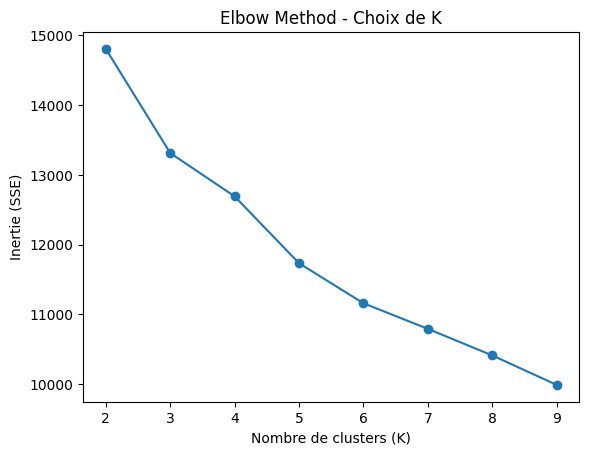

In [12]:
# =========================
# Méthode Elbow : on regarde la baisse de l'inertie quand K augmente.
# L'idée : à un moment, la baisse devient faible -> "coude".
# =========================

inertias = []
K_range = range(2, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=config["seed"], n_init="auto")
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

plt.figure()
plt.plot(list(K_range), inertias, marker="o")
plt.xlabel("Nombre de clusters (K)")
plt.ylabel("Inertie (SSE)")
plt.title("Elbow Method - Choix de K")
plt.show()


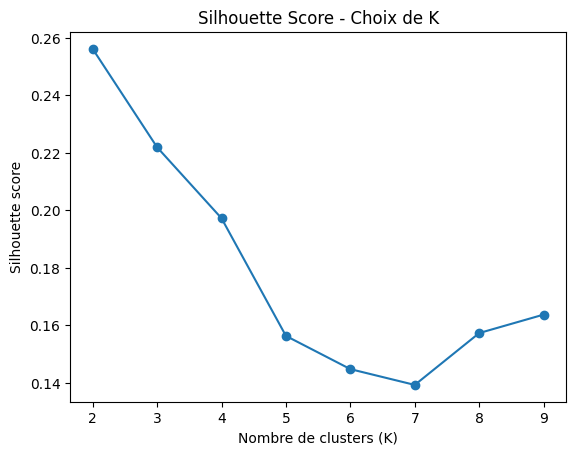

✅ Best K (silhouette): 2


In [13]:
# =========================
# Silhouette : mesure la qualité de séparation entre clusters.
# Plus proche de 1 = mieux (en général).
# =========================

sil_scores = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=config["seed"], n_init="auto")
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    sil_scores.append(score)

plt.figure()
plt.plot(list(K_range), sil_scores, marker="o")
plt.xlabel("Nombre de clusters (K)")
plt.ylabel("Silhouette score")
plt.title("Silhouette Score - Choix de K")
plt.show()

best_k = list(K_range)[int(np.argmax(sil_scores))]
print("✅ Best K (silhouette):", best_k)


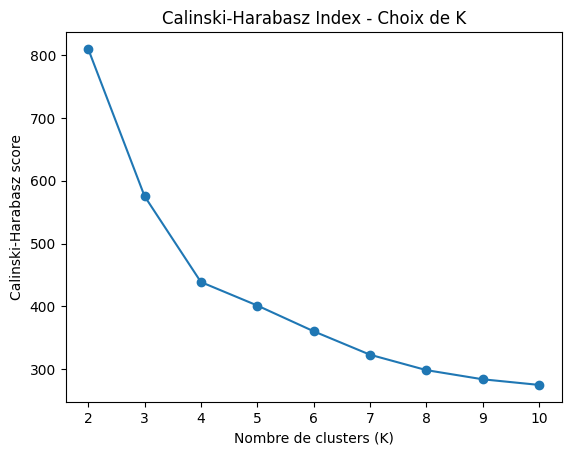

✅ Best K (Calinski-Harabasz): 2


In [19]:
from sklearn.metrics import calinski_harabasz_score

ch_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=config["seed"], n_init="auto")
    labels = kmeans.fit_predict(X)
    score = calinski_harabasz_score(X, labels)
    ch_scores.append(score)

# Visualisation
plt.figure()
plt.plot(list(K_range), ch_scores, marker="o")
plt.xlabel("Nombre de clusters (K)")
plt.ylabel("Calinski-Harabasz score")
plt.title("Calinski-Harabasz Index - Choix de K")
plt.show()

best_k_ch = list(K_range)[int(np.argmax(ch_scores))]
print("✅ Best K (Calinski-Harabasz):", best_k_ch)


In [ ]:
# On prend le meilleur K 
K_FINAL = 5

kmeans_final = KMeans(n_clusters=K_FINAL, random_state=config["seed"], n_init="auto")
labels = kmeans_final.fit_predict(X)

print("✅ Modèle entraîné avec K =", K_FINAL)
print("Inertie:", kmeans_final.inertia_)
print("Silhouette:", silhouette_score(X, labels))


✅ Modèle entraîné avec K = 5
Inertie: 11733.21936835448
Silhouette: 0.15634204331104934


In [27]:
models_dir = Path(config["paths"]["models"])
models_dir.mkdir(parents=True, exist_ok=True)

model_path = models_dir / f"kmeans_k{K_FINAL}.joblib"
dump(kmeans_final, model_path)

print("✅ Modèle sauvegardé:", model_path.resolve())

# Sauvegarder les labels avec l'ID client (si possible)
# Comme df_X est "features_scaled.csv", il n'a pas forcément l'ID.
# Donc on sauvegarde juste les labels liés à l'ordre des lignes.
out_labels_path = models_dir / f"cluster_labels_k{K_FINAL}.csv"
pd.DataFrame({"cluster": labels}).to_csv(out_labels_path, index=False)

print("✅ Labels sauvegardés:", out_labels_path.resolve())


✅ Modèle sauvegardé: C:\customer_segmentation\models\kmeans_k5.joblib
✅ Labels sauvegardés: C:\customer_segmentation\models\cluster_labels_k5.csv


In [24]:
from src.data.process_features import run_feature_processing

# Recrée df_selected (les colonnes data_keep en format "humain")
df_selected, X_tmp, feature_names_tmp, data_keep = run_feature_processing(config)

# On vérifie qu'on a le même nombre de lignes
print("df_selected:", df_selected.shape)
print("labels:", labels.shape)

# On ajoute la colonne cluster
df_selected_with_cluster = df_selected.copy()
df_selected_with_cluster["cluster"] = labels

df_selected_with_cluster.head(10)
out_clustered_path = processed_dir / f"features_with_clusters_k{K_FINAL}.csv"

✅ Data Process terminé
➡️ Fichier final : C:\customer_segmentation\data\processed\features_scaled.csv
➡️ Pipeline sauvegardé : C:\customer_segmentation\data\processed\preprocessor.joblib
➡️ data_keep utilisé : ['Income', 'total_spending', 'since_customer', 'Age', 'total_children', 'Recency', 'NumStorePurchases', 'NumWebPurchases', 'AcceptedAny']
df_selected: (2240, 9)
labels: (2240,)


In [ ]:
# Résumé : moyenne de chaque feature par cluster
cluster_summary = df_selected_with_cluster.groupby("cluster").mean(numeric_only=True)
cluster_summary
cluster_summary.to_csv(out_clustered_path)


In [25]:
reports_dir = Path(config["paths"]["reports"])
reports_dir.mkdir(parents=True, exist_ok=True)

out_report = reports_dir / f"cluster_summary_k{K_FINAL}.csv"
cluster_summary.to_csv(out_report)

print("✅ Rapport cluster summary sauvegardé:", out_report.resolve())


✅ Rapport cluster summary sauvegardé: C:\customer_segmentation\reports\cluster_summary_k5.csv
